# Multiple Linear Regression (for model evaluation)
* The Multiple Linear Regression model is trained on the train set and is used to predict China's HRC prices from the VAR forecasted independent variables.

In [595]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [596]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [597]:
# Define X and y variables
X = df[['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']]
y = df['HRC (FOB, $/t)']

In [598]:
# Log transform X variables
def log_trans(df):
    negative_cols = df.columns[df.min() < 0]

    df_transformed = df.copy()
    for col in negative_cols:
        constant = abs(df[col].min()) + 1
        df_transformed[col] = np.log(df[col] + constant)

    for col in df.columns.difference(negative_cols):
        df_transformed[col] = np.log(df[col])
    
    return df_transformed

X_transformed = log_trans(X)

In [599]:
# Split into train and test set (split is done in the same way as that for the VAR model)
X_train, X_test = X_transformed[0:-17], X_transformed[-17:]
y_train, y_test = y[0:-17], y[-17:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201, 9)
(17, 9)
(201,)
(17,)


#### Multiple Linear Regression formula
$$ y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n + \epsilon $$

In [600]:
# Model fitting on train set
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [601]:
# Obtain regression model coefficients
print('Intercept: ', model.intercept_)
list(zip(X, model.coef_))

Intercept:  -2501.6426629754687


[('Iron Ore (CFR, $/t)', 20.429845627001278),
 ('HCC (Aus FOB, $/t)', 98.4072636309904),
 ('Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 352.0978659079065),
 ('Monthly Export of Semis & Finished Steel as % of Production',
  111.15696046233833),
 ('FAI in urban real estate development (y-o-y) Growth', -5.6096137463202504),
 ('Automobile Production (y-o-y)', 43.209200552803544),
 ('Civil Metal-Vessels/Steel Ships (y-o-y)', 18.723656977937182),
 ('Household Fridges (y-o-y)', 32.21469829822672),
 ('Air Conditioner (y-o-y)', -53.22574151857871)]

In [602]:
# Obtain VAR forecasted X variables (test set)
var_testset = pd.read_csv('../data/final/var_testset.csv')

X_vartest = var_testset[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()

X_vartest.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)

X_vartest_transformed = log_trans(X_vartest)

In [603]:
# Predict China's HRC prices
y_pred = model.predict(X_vartest_transformed)

In [604]:
# Prepare dataframes for graph plotting
df_train, df_test = df[0:-17], df[-18:]

y_pred_new = np.insert(y_pred, 0, df_train['HRC (FOB, $/t)'][-1]) #adding the last value from the train set to have a smooth line when plotting
fc_duration = pd.date_range(start=df_train.index[-1], periods=18, freq='MS')
df_pred = pd.DataFrame(y_pred_new, index=fc_duration, columns=['HRC (FOB, $/t)_pred'])
df_pred.index.name = 'Date'
df_pred

,"HRC (FOB, $/t)_pred"
Date,
2023-05-01,561.000000
2023-06-01,432.260403
2023-07-01,431.019480
2023-08-01,457.512991
2023-09-01,476.477486
2023-10-01,483.070781
2023-11-01,491.283070
2023-12-01,499.475168
2024-01-01,500.859774


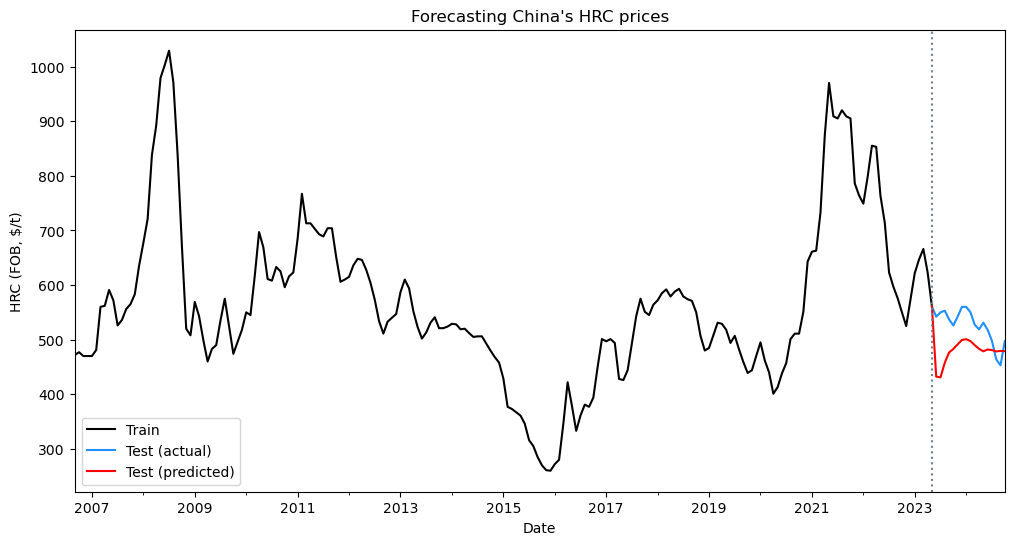

In [605]:
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

df_train['HRC (FOB, $/t)'].plot(color='k', label='Train')
df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_pred['HRC (FOB, $/t)_pred'].plot(color='r', label='Test (predicted)')

plt.title("Forecasting China's HRC prices")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = df_train.index[-1], color = 'slategray', linestyle = 'dotted')
ax.legend()

(641.0, 657.0)

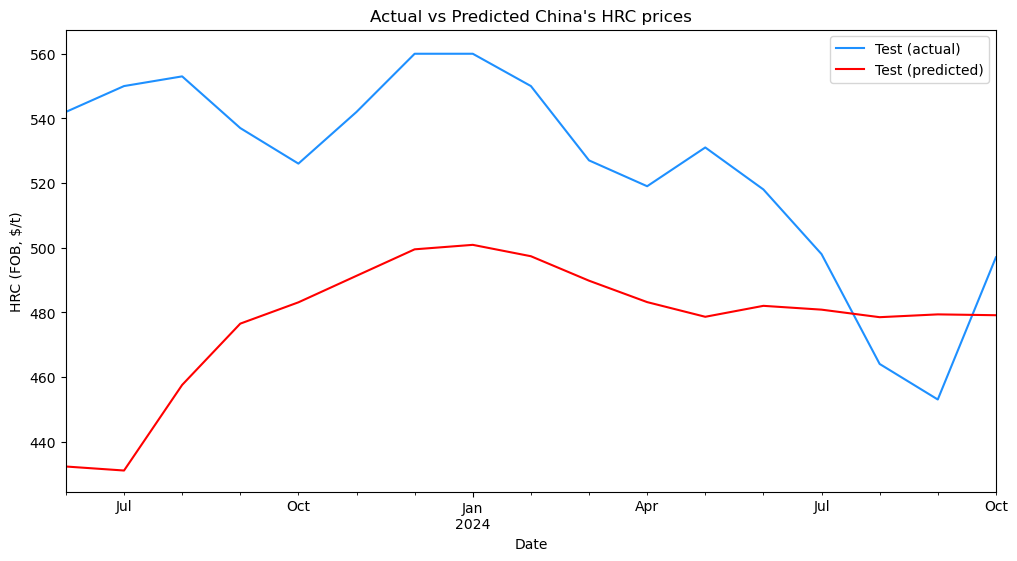

In [606]:
# Compare forecasted with actual results (zoom into test set)
fig, ax = plt.subplots(figsize=(12, 6))

df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_pred['HRC (FOB, $/t)_pred'].plot(color='r', label='Test (predicted)')

plt.title("Actual vs Predicted China's HRC prices")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()
ax.set_xlim(left=pd.Timestamp('2023-06-01'))

In [607]:
# Error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  52.24331055779176
Mean Squared Error:  3621.4269887272544
Root Mean Squared Error:  60.178293335115896
Mean Absolute Percentage Error:  0.0974512595930572


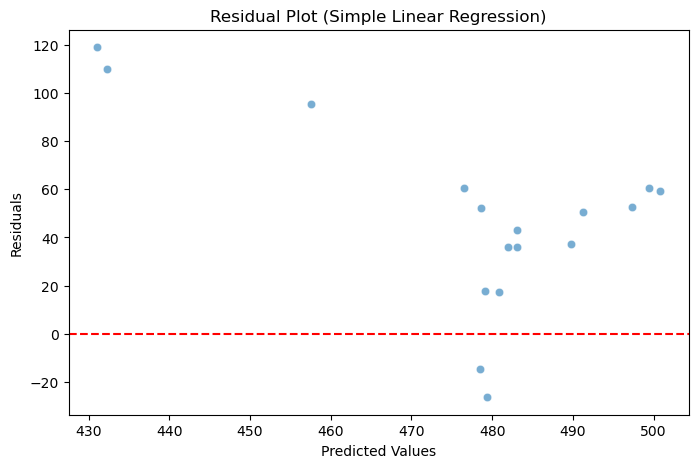

In [608]:
residuals = y_test - y_pred  # Compute residuals

# Plot residuals vs. predicted values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)  # Scatter plot
plt.axhline(y=0, color="red", linestyle="--")  # Horizontal line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Simple Linear Regression)")
plt.show()

# Multiple Linear Regression (for actual forecast)
* The Multiple Linear Regression model is trained on the full dataset.

In [609]:
# Model fitting on full dataset
lr_model = LinearRegression()
lr_model.fit(X_transformed, y)

LinearRegression()

In [610]:
# Obtain regression model coefficients
print('Intercept: ', lr_model.intercept_)
list(zip(X, lr_model.coef_))

Intercept:  -2241.0846225147875


[('Iron Ore (CFR, $/t)', 2.752649552553431),
 ('HCC (Aus FOB, $/t)', 91.88975374016223),
 ('Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 339.5471227744394),
 ('Monthly Export of Semis & Finished Steel as % of Production',
  81.48254129080179),
 ('FAI in urban real estate development (y-o-y) Growth', 43.37611122892593),
 ('Automobile Production (y-o-y)', 40.460396198891075),
 ('Civil Metal-Vessels/Steel Ships (y-o-y)', 17.24660369497111),
 ('Household Fridges (y-o-y)', -22.23165843887375),
 ('Air Conditioner (y-o-y)', -41.08185188272788)]

In [611]:
# Obtain VAR forecasted X variables
var_forecast_df = pd.read_csv('../data/final/var_forecast_actual.csv')
var_forecast_df.set_index('Date', inplace=True)
var_forecast_df.index = pd.to_datetime(var_forecast_df.index)

forecasted_X = var_forecast_df[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()

forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)

In [612]:
# Log transform VAR forecasted X variables
forecasted_X_transformed = log_trans(forecasted_X)

In [613]:
# Predict China's HRC price forecast
y_forecast = lr_model.predict(forecasted_X_transformed)
y_forecast_new = np.insert(y_forecast, 0, df['HRC (FOB, $/t)'][-1]) #adding 10/1/2024 value to have a smooth line when plotting

fc_period = pd.date_range(start=df.index[-1], periods=18, freq='MS')
df_forecast = pd.DataFrame(y_forecast_new, index=fc_period, columns=['HRC (FOB, $/t)_f'])
df_forecast.index.name = 'Date'
df_forecast

,"HRC (FOB, $/t)_f"
Date,
2024-10-01,497.000000
2024-11-01,461.013121
2024-12-01,500.368320
2025-01-01,489.986949
2025-02-01,472.581182
2025-03-01,477.078801
2025-04-01,480.810067
2025-05-01,483.187875
2025-06-01,470.386576


In [614]:
# Export China's forecasted HRC prices to a csv file
df_forecast.to_csv('../data/final/multireg_forecast.csv', index=True)

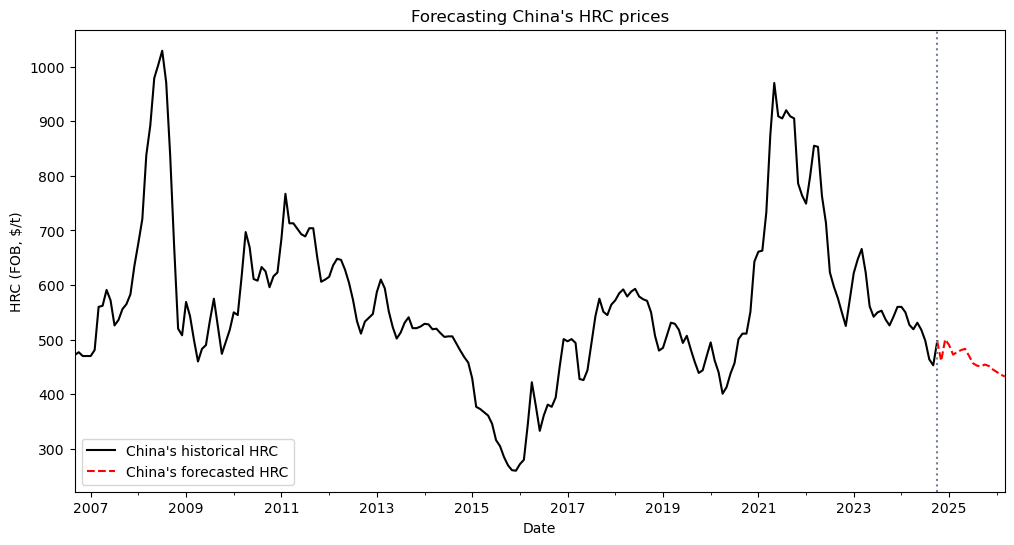

In [615]:
# Plot forecast
fig, ax = plt.subplots(figsize=(12, 6))

df['HRC (FOB, $/t)'].plot(color='k', label="China's historical HRC")
df_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label="China's forecasted HRC")

plt.title("Forecasting China's HRC prices")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-10-01', color = 'slategray', linestyle = 'dotted')
ax.legend()

#### Forecast China's upside and downside HRC prices

In [616]:
# Define code for forecasting China's upside and downside HRC prices
def create_forecast_region(iron_ore, hcc, scrap, export_perc, fai, var_forecast):
    # Initialise df
    fc_p = pd.date_range(start=var_forecast.index[0], end=var_forecast.index[-1], freq='MS')
    up_down_df = pd.DataFrame(np.nan, index=fc_p, columns=['Iron Ore (CFR, $/t)',
                                               'HCC (Aus FOB, $/t)',
                                               'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
                                               'Monthly Export of Semis & Finished Steel as % of Production',
                                               'FAI in urban real estate development (y-o-y) Growth',
                                               'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
                                               'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'])
    up_down_df.index.name = 'Date'

    # Use upside/downside values for the following X variables
    up_down_df['Iron Ore (CFR, $/t)'] = iron_ore
    up_down_df['HCC (Aus FOB, $/t)'] = hcc
    up_down_df['Domestic Scrap (DDP Jiangsu incl. VAT $/t)'] = scrap
    up_down_df['Monthly Export of Semis & Finished Steel as % of Production'] = export_perc
    up_down_df['FAI in urban real estate development (y-o-y) Growth'] = fai

    # Use VAR forecasted values for the following X variables since upside/downside values are not available
    up_down_df['Automobile Production (y-o-y)'] = var_forecast['Automobile Production (y-o-y)_forecast']
    up_down_df['Civil Metal-Vessels/Steel Ships (y-o-y)'] = var_forecast['Civil Metal-Vessels/Steel Ships (y-o-y)_forecast']
    up_down_df['Household Fridges (y-o-y)'] = var_forecast['Household Fridges (y-o-y)_forecast']
    up_down_df['Air Conditioner (y-o-y)'] = var_forecast['Air Conditioner (y-o-y)_forecast']
    
    # Log transform variables
    up_down_transformed = log_trans(up_down_df)

    # Predict China's upside/downside HRC prices
    up_down_f = lr_model.predict(up_down_transformed)
    up_down_f_new = np.insert(up_down_f, 0, df['HRC (FOB, $/t)'][-1])

    fc_dates = pd.date_range(start=df.index[-1], periods=18, freq='MS')
    up_down_forecast = pd.DataFrame(up_down_f_new, index=fc_dates, columns=['HRC (FOB, $/t)'])
    up_down_forecast.index.name = 'Date'
    return up_down_forecast


In [617]:
# Forecasting China's upside and downside HRC prices
df_forecast_downside = create_forecast_region(85, 180, 350, 12, 1, var_forecast_df)
df_forecast_upside = create_forecast_region(100, 220, 400, 9, 5, var_forecast_df)

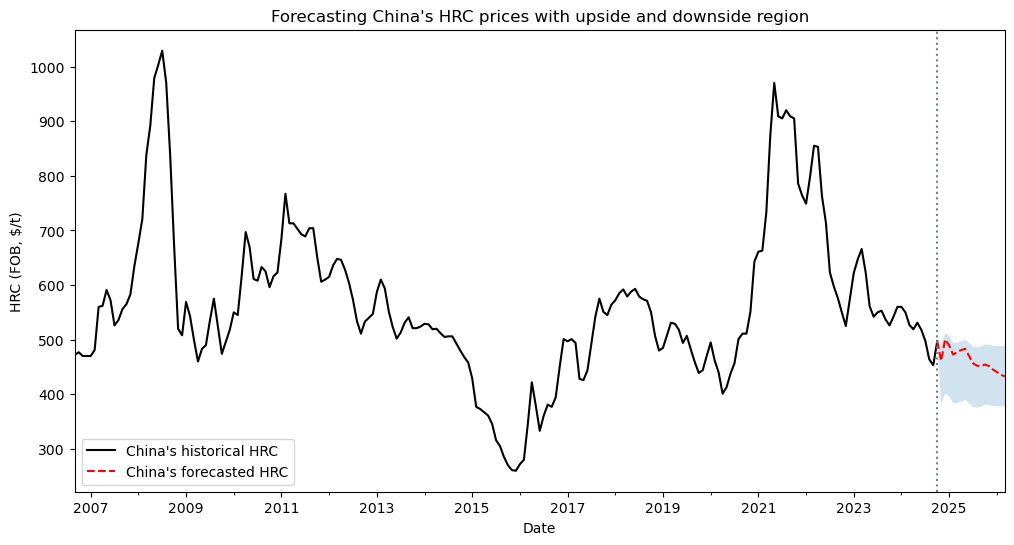

In [618]:
# Plot forecast with upside and downside region
fig, ax = plt.subplots(figsize=(12, 6))

df['HRC (FOB, $/t)'].plot(color='k', label="China's historical HRC")
df_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label="China's forecasted HRC")
fc_period = pd.date_range(start=df.index[-1], periods=18, freq='MS')
ax.fill_between(x=fc_period, y1=df_forecast_downside['HRC (FOB, $/t)'], y2=df_forecast_upside['HRC (FOB, $/t)'], alpha=0.2)

plt.title("Forecasting China's HRC prices with upside and downside region")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-10-01', color = 'slategray', linestyle = 'dotted')
ax.legend()